In [ ]:
import numpy as np
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter
from skimage import exposure
from numpy.ma import getdata
from skimage.filters import sobel
from skimage import filters

from matplotlib import pyplot as plt
import plotly.graph_objects as go
plt.style.use('dark_background')
import matplotlib as mpl
from pypalettes import load_cmap
palette = load_cmap('Alexandrite')


# Benchmarking the fitting method

A measure of the error of this method is necessary, both for the characterization of the method itself, but also for an in-orbit metric of its accuracy. We will attempt the first through comparison with the simulation and the latter through the image data alone.

(shue-to-shue-cube)=
## Image-fitted Shue to cube-fitted Shue

We can characterize the method by benchmarking it to the expected position of the magnetopause according to the simulation cube. As we saw in {ref}`section:extract_magnetopause`, extracting the true magnetopause from the cube is not as simple as it appears, the main obstacles being the inhomogeneous behavior of the test particles, but more importantly the ambiguity of defining such a surface consistently. We can, however, run a simple test by comparing the fitted Shue surface to the Shue surface that can best describe the 3D simulation data - a model fitted directly to the cube. For simplicity, we will use the parameters that were fitted in {ref}`subsec:shue-fit` - $r_0 = 7.82 \, RE$ and $\alpha = 0.386$.

Running the Hough method for a full orbit, we can get the evolution of the estimated parameters, as well as their error compared to the initial model. We can do this by initializing an `Images` object and calling the `hough` method for each of the images of the selected folder.

In [2]:
from TangentFitting import Images
img = Images(folder_name = "01.08.2025-03.08.2025-Res0.5")

r0_fit = np.linspace(6, 9, 10)
a_fit = np.linspace(0.1, 1, 10)

i = 0
r0_max = np.zeros(len(img.images))
a_max = np.zeros(len(img.images))

for i in tqdm(range(len(img.images))):
    img.choose_image(i)
    hough_matrix, r0_max[i], a_max[i] = img.hough(r0_fit, a_fit)

100%|██████████| 49/49 [03:29<00:00,  4.28s/it]


We can also plot the maximum intensity arc, initial cube-fitted Shue model and hough-fitted Shue model for each snapshot of the orbit and compare them:

100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


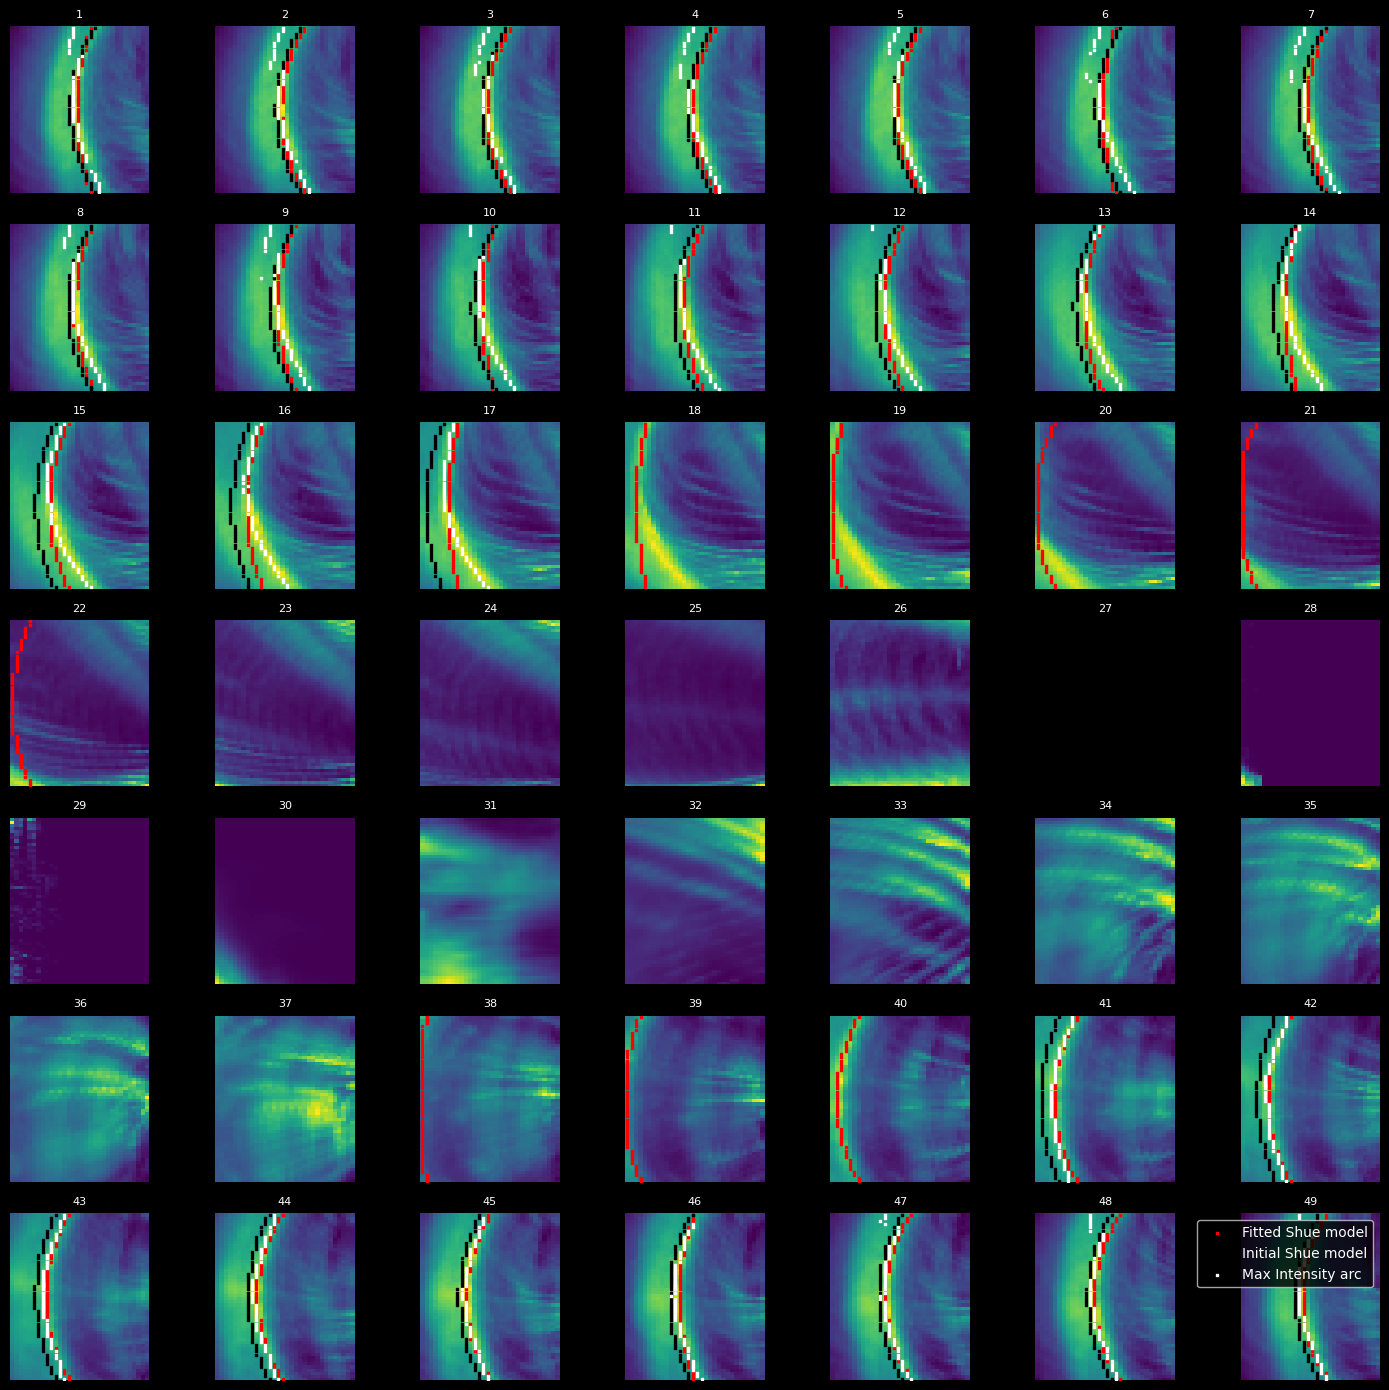

In [ ]:
n = 7  # 7 rows and 7 columns

fig, axes = plt.subplots(n, n, figsize=(14, 14))  # Bigger figure for clarity

RMSE = np.zeros(n*n)
RMSE_arc = np.zeros(n*n)
# z_sat = np.zeros(n*n)
# std_z = np.zeros(n*n)
for i in tqdm(range(n * n)):
    row = i // n
    col = i % n
    ax = axes[row, col]

    img.choose_image(i)
    image = np.array(getdata(img.image))
    equalized_image = exposure.equalize_hist(image)
    smoothed_eq_image = filters.gaussian(equalized_image, sigma=1)
    sobel = filters.sobel(image)

    # Find maximum intensity curve
    max_x = []
    y_vals = np.arange(image.shape[0])
    for y in y_vals:
        # Choose image processing (original, sobel, contrast)
        row = smoothed_eq_image[y, :]
        x = np.argmax(row)
        max_x.append(x)
    max_x = np.array(max_x)
    max_x_filtered = [max_x[0]]
    y_filtered = [y_vals[0]]
    for j in range(1, len(max_x)):
        if abs(max_x[j] - max_x_filtered[-1]) <= 3:  # Set tolerance for jumps
            max_x_filtered.append(max_x[j])
            y_filtered.append(y_vals[j])
    threshold = 0.2  # threshold for intensity of the curve (inside magnetopause low)
    curve_intensity = np.mean(image[y_vals, max_x])
    if curve_intensity < 0.3:
        y_filtered = []
        max_x_filtered = []
    if len(y_filtered) < 20:
        y_filtered = []
        max_x_filtered = []

    
    ax.pcolormesh(img.Az, img.El, img.images[i], cmap='viridis', shading='auto')
    ax.axis('off')  # Hide axes for a cleaner look
    ax.set_title(f"{i+1}", fontsize=8)

    # Print Hough Fitted model
    az_fit, el_fit = img.shue_tangent_SXI(r0_max[i], a_max[i])
    if az_fit is None or el_fit is None :
        # print(f"Image{i} is inside magnetopause")
        r0_max[i], a_max[i] = None, None
        continue
    ax.scatter(img.Az[el_fit,az_fit], img.El[el_fit,az_fit], s=2, color = 'red', marker = 's', label='Fitted Shue model')
    
    # Print Cube fitted shue model
    az_shue, el_shue = img.shue_tangent_SXI(7.818, 0.386)

    if az_shue is None or el_shue is None:
        # print(f"In image{i} the initial shue surface is outside the FOV")
        continue
    ax.scatter(img.Az[el_shue,az_shue], img.El[el_shue,az_shue], s=2, color = 'black', marker = 's', label='Initial Shue model')

    ax.scatter(img.Az[y_filtered,max_x_filtered],img.El[y_filtered,max_x_filtered] , s=2, color = 'white', marker = 's', label='Max Intensity arc')

    # Calculate RMSE between models and lines
    RMSE[i] = np.sqrt(np.mean((img.Az[el_shue,az_shue] - img.Az[el_fit,az_fit]) ** 2))
    image_at_tangent_points = img.Az[y_filtered, max_x_filtered]
    image_at_Imax = img.Az[el_fit, az_fit]
    N = min(len(image_at_tangent_points), len(image_at_Imax))
    if N>20:
        count = 0 
        Daz2=0
        for k in range(len(el_fit)):
            j = np.where(np.array(y_filtered) == el_fit[k])[0]
            if len(j)>0:
                j = j[0]
                Daz2 += (img.Az[el_fit[k],az_fit[k]]-img.Az[y_filtered[j],max_x_filtered[j]])**2
                count += 1
            else:
                continue
        RMSE_arc[i]=np.sqrt(Daz2/count)
    else:
        RMSE_arc[i]=None

plt.legend()
plt.tight_layout()
plt.show()  

We remind the reader that the simulation is a steady state instance and therefore the variability of the detected parameters is attributed solely to the viewing angle. Here we plot the evolution of the estimated subsolar distance $r_0$ with time, for a full summer orbit of August 2025. Strong variation is observed depending on the position of the satellite. The clipping of the $r_0$ values is the result of the discretization of the parameter space in a grid. The green dotted lines, indicating low error detection, are correlated with POVs where the image arc appears symmetrical. The indentation of the cusps is responsible for this seeming asymmetry we observe in the corresponding snapshots (see indexes) of the red dotted lines.

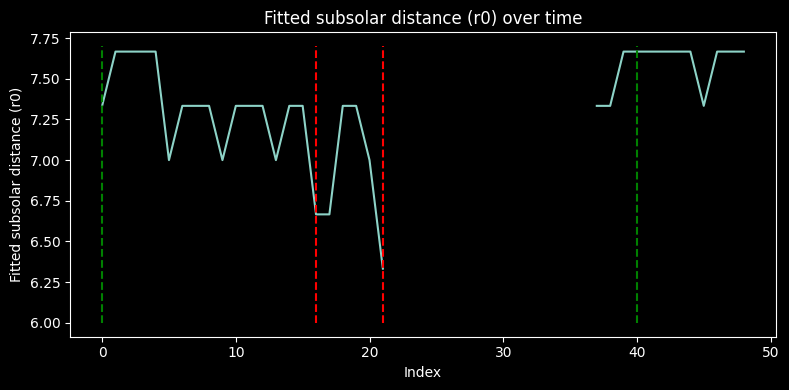

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(r0_max)
plt.vlines(16, 6, 7.7, colors="red",linestyles="--")
plt.vlines(21, 6, 7.7, colors="red",linestyles="--")
plt.vlines(40,6, 7.7, colors="green", linestyles= "--")
plt.vlines(0,6, 7.7, colors="green", linestyles= "--")

plt.xlabel("Index")
plt.ylabel("Fitted subsolar distance (r0)")
plt.title("Fitted subsolar distance (r0) over time")
plt.tight_layout()
plt.show()

This increase of the error is to be expected since the Shue model is symmetrical and does not describe any indentation, and therefore cannot capture these shapes. This is reflected in the evolution of the error plotted below, where in this orbit the satellite sees increasingly the cusp as it approaches the magnetopause.

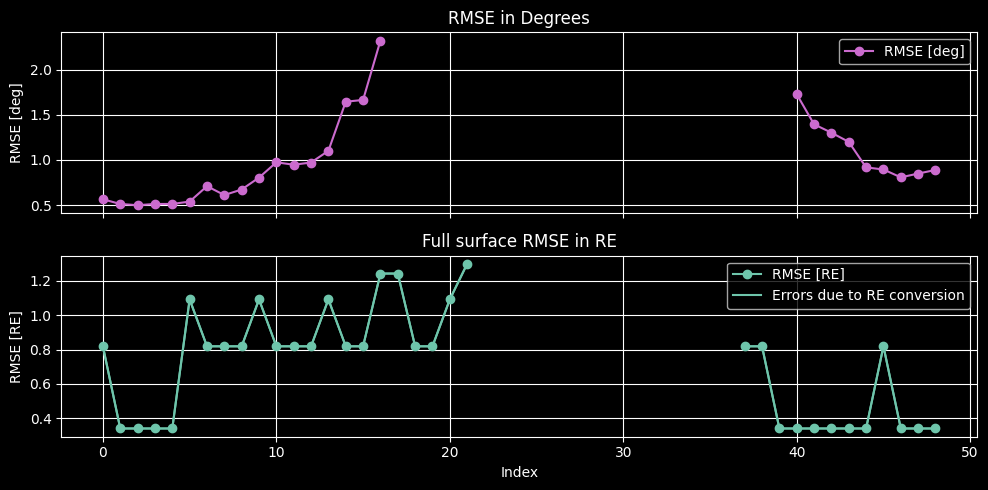

In [ ]:
import TangentFitting as tf
RMSE[RMSE == 0] = None
r0_init = 7.82
a_init = 0.386
theta_vals = np.linspace(-np.pi/2, np.pi/2, 500)
phi_vals = np.linspace(0, np.pi, 500)
Theta, Phi = np.meshgrid(theta_vals, phi_vals)

shue_init = tf.shue_num(r0_init, a_init, Theta, Phi)
RMSE_RE = np.zeros(len(img.images))
for i in range(len(img.images)):
    shue_fit = tf.shue_num(r0_max[i], a_max[i], Theta, Phi)
    RMSE_RE[i] = np.sqrt(np.mean((shue_fit - shue_init) ** 2))

fig, axs = plt.subplots(2, 1 , figsize=(10, 5), sharex=True)

axs[0].plot(RMSE, 'o-', label='RMSE [deg]', color = palette(1))
axs[0].set_ylabel('RMSE [deg]')
axs[0].set_title('RMSE in Degrees')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(RMSE_RE, 'o-', color=palette(7), label='RMSE [RE]')
axs[1].errorbar(np.arange(len(RMSE_RE)), RMSE_RE, color=palette(7), label='Errors due to RE conversion')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('RMSE [RE]')
axs[1].set_title('Full surface RMSE in RE')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Since, we are mainly interested in the subsolar distance estimation, it is useful to plot the deviation of $r_0$ from the initial parameter. We notice that for the symmetric cases, we get error close to $0.5\, RE$ which is the SXI requirement. This has a non-negligible contribution from the discretization of the parameter space and can be improved through the deployment of fitting schemes as will be discussed in {ref}`discussion`. Evidently, another important contribution in this error is the simplicity of the model itself, and can be improved by using more sophisticated models such as the Lin or the Liu model. However, these first test shows that although we used a sparsely sampled parameter space and a simplistic model, we can still get information about the subsolar distance with an error close to the requirement. We therefore expect the improvements suggested here to lead to increased accuracy.


Contrary to the subsolar distance, the flaring parameter is more challenging to be determined through this method. This is logical, since the asymmetry of the image arc would be interpreted as increased or decreased flaring in a symmetric model. To understand the capabilities of this method in regard to other parameters, we shall run this tests using more descriptive empirical models.

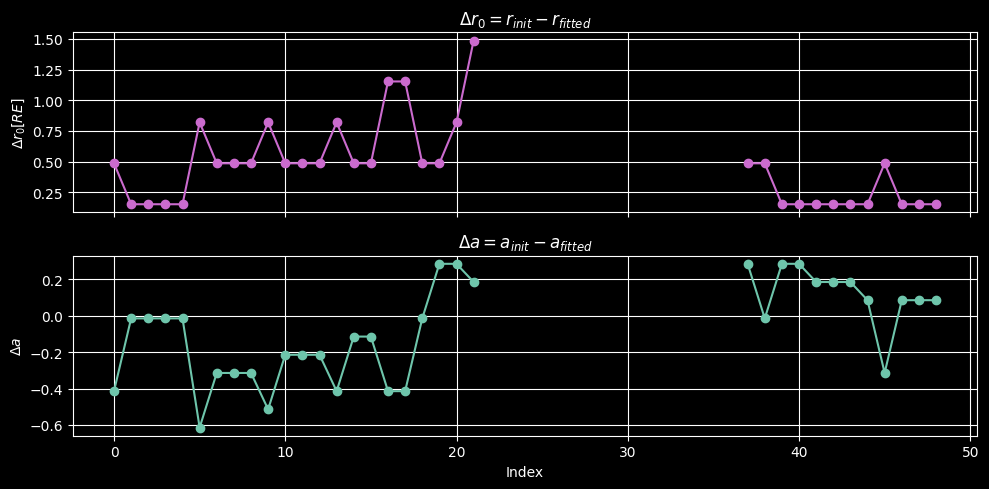

In [ ]:
r0_error = -(r0_max - r0_init)
a_error = -(a_max - a_init)


fig, axs = plt.subplots(2, 1 , figsize=(10, 5), sharex=True)

axs[0].plot(r0_error, 'o-', label='Error [RE]', color = palette(1))
axs[0].set_ylabel('$\Delta r_0 [RE]$')
axs[0].set_title('$\Delta r_0 = r_{init}-r_{fitted}$')
axs[0].grid(True)

axs[1].plot(a_error, 'o-', color=palette(7), label='Error [-]')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('$\Delta a$')
axs[1].set_title('$\Delta a = a_{init}-a_{fitted}$')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Characterization through maximum intensity curve 


Although we expect the simulation to be representative of the magnetopause to some extent, we also expect to be surprised. Having a metric to characterize our measurement without a simulation dependency is crucial for the analysis of the real data. We can achieve this by benchmarking the fitted curve to the maximum intensity arc of the image. Thus, we can have a metric of the error of the fit, but also of the agreement of the empirical model to the true shape of the magnetopause. 

The latter is particularly important, since it is challenging to derive the global shape of the magnetopause from in-situ measurements alone - meaning that there is still disagreement on its shape and its response to the solar wind. Using a non-representative empirical surface would automatically result in different projected curve geometries, that could not capture the maximum arc shape, no matter the fitting process. The error therefore, between the fitted models through the Hough method and the maximum intensity arc can be used as a metric to characterize the empirical model themselves.


The evolution of this metric for the August orbit is plotted below. Here we have contribution both from the arc extraction problems that we were facing in {ref}`max_int_arc`, and from the fitting errors we analyzed above. Better image processing is crucial for this metric to return a reliable estimation of the empirical model error alone. This can be seen in the first snapshot of the orbit, where there seems to be a good fit of the model, but the maximum intensity arc extraction fails. However, cases like the symmetric view of snapshot 43 combined with the extraction of the intended arc, return promising results.

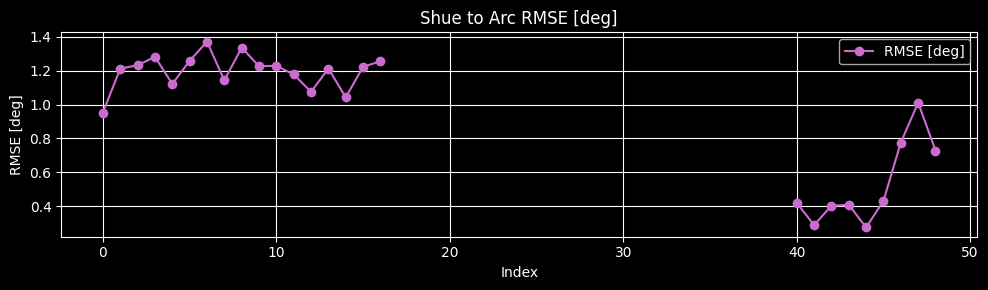

In [ ]:
RMSE[RMSE == 0] = None
RMSE_arc[RMSE_arc == 0] = None

plt.figure( figsize=(10, 3))

plt.plot(RMSE_arc, 'o-', label='RMSE [deg]', color = palette(1))
plt.ylabel('RMSE [deg]')
plt.title('Shue to Arc RMSE [deg]')
plt.legend()
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()